# Plotting sea ice time series and histograms

### Author: Chris Wyburn-Powell, find the most up-to-date version on [github](https://github.com/chrisrwp/ATOC_4500) <br>

#### **ATOC 4500-003**, Fall 2021 at CU Boulder. Taught by Professor Alexandra Jahn, and teaching assistant Chris Wyburn-Powell <br>

**This notebook provides an intoduction to CMIP5 Large Ensembles and CMIP6 models for sea ice. The plotting examples are for sea ice area (SIA), but sea ice extent (SIE) and sea ice volume (SIV) can be plotted in the same way** <br>

**Skills learned:**
- Opening `NetCDF` and `text` files
- Manipulating `xarray` datatsets
- Plotting time series and histograms with `matplotlib`
- Calculating a normal distribution with `scipy`

## Prerequisites

Please use the `ATOC_4500_Python_env` by running in your terminal the following commmands replacing <> with your path: <br>
`conda activate </opt/anaconda3/envs/>ATOC_4500_Python_en>` <br>
`jupyter lab` <br>

Please ensure you have downloaded files in the following directories from [Google Drive](https://drive.google.com/drive/u/0/folders/1HvYoLNhBrcQP2VvMMH3xqfDt82oysSFR):
- `CLIVAR_CMIP5_SIA_SIE_SIV` This is sea ice area, exetent and volume for 6 CMIP5 large ensembles
- `SIA_CMIP6` This is sea ice area for the ensemble mean of all availible CMIP6 models



# Tutorial Start
## Import libraries, documentation linked below:
- [`pandas`](https://pandas.pydata.org/) Data analysis, particularly useful for `txt` and `csv` files
- [`numpy`](https://numpy.org/) Scientific arrays with easy computation across elements
- [`xarray`](http://xarray.pydata.org/en/stable/) Multi-dimensional labeled arrays, built on numpy and pandas
- [`matplotlib`](https://matplotlib.org/) Plotting library built on matlab functionality
- [`scipy`](https://www.scipy.org/) Statistics
- [`datetime`](https://docs.python.org/3/library/datetime.html) Computation with dates and times

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime

# CMIP5 data
**Firstly define the path to the directory where you have saved the data** <br>
**We can use `Linux` commands within Jupyter notebooks if you preface your code with an** `!`

In [2]:
!pwd

/Users/chwy8767/Documents/ATOC_4500


**Change the path to where you've downloaded all the data**

In [3]:
data_path = '/Users/chwy8767/Downloads/ATOC_4500/'

**Open the CMIP5 data with** `xarry`

In [4]:
SIA_CMIP5 = xr.open_dataset(data_path+'CLIVAR_CMIP5_SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')

In [5]:
SIA_CMIP5 #have a look at the dataset

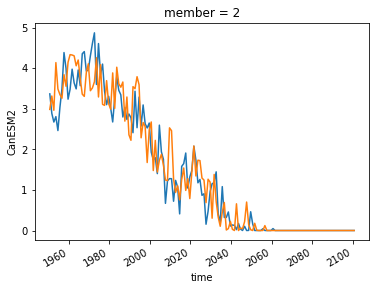

In [6]:
#quickly plot a couple of members from the CanESM2 large ensemble
model_name = 'CanESM2'
month_ = 9
SIA_CMIP5[model_name].sel(time=SIA_CMIP5['time.month']==month_).sel(member=1).plot()
SIA_CMIP5[model_name].sel(time=SIA_CMIP5['time.month']==month_).sel(member=2).plot();

## Plot the ensemble member mean and standard deviation

In [7]:
model_names  = ['CanESM2', 'CESM1', 'CSIRO_MK36', 'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1' ]
month_names  = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'November', 'December']
mem_len      = [50,        40,      30,           20,         30,           100        ]
model_starts = [1950,      1920,    1850,         1920,       1950,         1850       ]
colors       = ['m',       'b',     'g',          'orange',   'k',          'tab:olive']

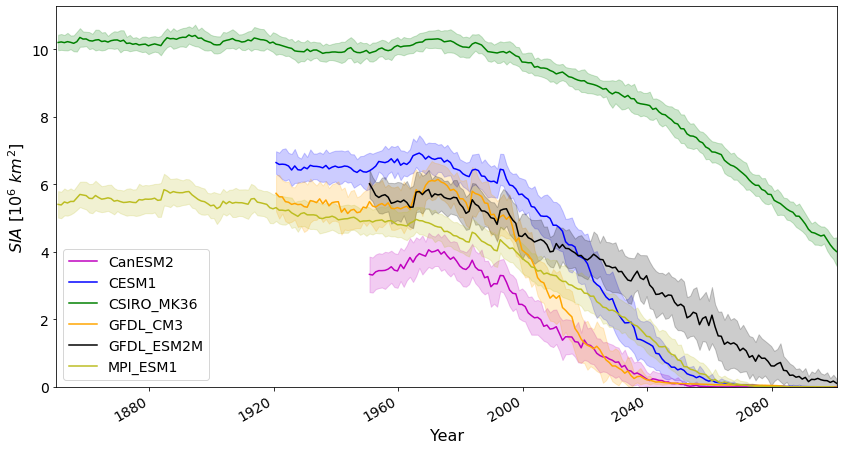

In [87]:
month_ = 9 #choose the month

plt.figure(figsize=[14,7]) #initialize a matplotlib figure of size 14,7 inches

########## loop through the 6 models ##########
for model_i, model_name in enumerate(list(SIA_CMIP5.keys())): 
    #select the month and model we're looking for
    model_data = SIA_CMIP5[model_name].sel(time=SIA_CMIP5['time.month']==month_)\
                                      .sel(time=slice(str(model_starts[model_i]),'2100'))
    
    if model_name == 'CESM1':
        model_data = model_data.sel(time=slice('1920','2100')) #CESM1 only has 1 member 1850-1919, don't plot for those years
    elif model_name == 'MPI_ESM1':
        model_data = model_data.sel(time=slice(str(model_starts[model_i]),'2099')) #MPI only goes up to the year 2099
    
    model_data.mean('member').plot(c=colors[model_i], label=model_name) #plot the member mean
    
    #plot the standard deviation as shading above and below the mean
    plt.fill_between(model_data['time'].values, model_data.mean('member') - model_data.std('member'), 
                     model_data.mean('member') + model_data.std('member'), color=colors[model_i], alpha=0.2)


########## after all models have been plotted, improve axes ##########
plt.legend(fontsize=14) #make the legend font size larger

plt.xlim(SIA_CMIP5['time'].min().values, SIA_CMIP5['time'].max().values) #remove white space at the edges of the x axis
plt.xlabel('Year', fontsize=16);
plt.xticks(fontsize=14)

plt.ylim(bottom=0)
plt.ylabel(r'$SIA \ [10^6 \ km^2]$', fontsize=16) #you can use latex in matplotlib if you put an r before the string
plt.yticks(fontsize=14);

## Plot historgrams of the SIA data

**Select the model** `MPI ESM1` **for the years 1850-1960 (where there is a small trend in sea ice area)** <br>
**Is this data normally distributed?**


In [13]:
MPI_Sep_1850_1960 = SIA_CMIP5['MPI_ESM1'].sel(time=SIA_CMIP5['time.month']==month_).sel(time=slice('1850','1960'))

In [18]:
MPI_Sep_1850_1960 #take a look at the data

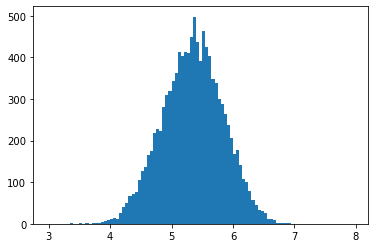

In [14]:
plt.hist(np.ravel(MPI_Sep_1850_1960), bins=np.arange(3,8,0.05)); #we need np.ravel to make the data 1D (length [11100] instead of [100,111])

### Plot a Gaussian curve to the histogram
**The data above should loook approximately normally distributed, let's aid our visual analysis by overlaying a gaussian fit**

In [19]:
def PDF(data):
    '''
    Caclulates x values and corresponding probabilities for an xarray data array
    
    Parameters
    ----------
    data : an array of most types and shapes,
        This should be the same data you input into matplotlib.pyplot.hist
    
    Returns
    ----------
    x_vals: numpy array
        100 elements equally spaced along the x axis, -5 standard deviations to +5 from the mean
    probs: numpy array
        The 100 corresponding probabilities to the x_vals
    '''
    
    distrib = stats.norm(np.mean(data), np.std(data))
    x_vals  = np.linspace(np.mean(data)-np.std(data)*5, np.mean(data)+np.std(data)*5,100)
    probs   = [distrib.pdf(x) for x in x_vals]
    
    return(x_vals, probs)

In [21]:
help(PDF) #a quick way of looking up how a function works 
#this can be quicker than going through the documentation of large libraries e.g. numpy - try help(np.mean)

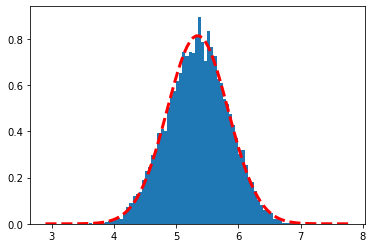

In [22]:
gaussian_vals = PDF(MPI_Sep_1850_1960.values)

plt.hist(np.ravel(MPI_Sep_1850_1960), bins=np.arange(3.5,7,0.05), density=True);
plt.plot(gaussian_vals[0], gaussian_vals[1], color='r', linestyle='--', linewidth=3);

# CMIP6 data
**Now load the data for CMIP6 models** <br>

**First, let's look at the** `SIA_CMIP6_ssp585_September.txt` **file using a Linux command** `!head` <br>

In [25]:
!head /Users/chwy8767/Downloads/ATOC_4500/SIA_CMIP6/SIA_CMIP6_ssp585_September.txt

**That output is rather messy, let's use the Python package** `pandas` **to open it nicely**

In [34]:
CMIP6_09_SSP585_pd = pd.read_csv(data_path+'SIA_CMIP6/SIA_CMIP6_ssp585_September.txt')

In [37]:
CMIP6_09_SSP585_pd #pandas displays this in a much easier to read way!

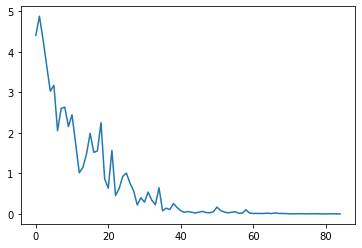

In [36]:
CMIP6_09_SSP585_pd['ACCESS-CM2'].plot(); #quickly plot the data from one model called ACCESS-CM2

**Now let's convert the** `pandas DataFrame` **into an xarray dataset**

In [42]:
CMIP6_09_SSP585 = xr.Dataset(CMIP6_09_SSP585_pd)
CMIP6_09_SSP585

**We want to use** `Year` **as our coordinates for dimension 0 (**`dim_0`**) and remove** `Year` **as a variable**

In [43]:
CMIP6_09_SSP585['dim_0'] = CMIP6_09_SSP585['Year'] #we have a dimension without coordinates
#'Year' isn't a model but it is a dataset, remove that. Now we rename our 'dim_0' as 'Year' 
CMIP6_09_SSP585 = CMIP6_09_SSP585.drop('Year').rename({'dim_0':'Year'}) 
CMIP6_09_SSP585 #now let's have a look at what we've made

**Now let's plot all of the data in that file**

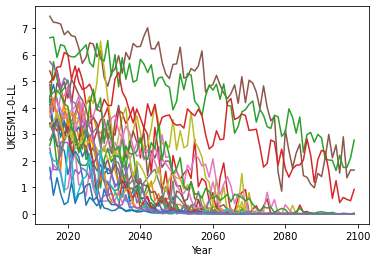

In [46]:
for model in list(CMIP6_09_SSP585.keys()): #loop through all the models (xarray variables)
    CMIP6_09_SSP585[model].plot()

**Now let's make it a little easier to readby adding extra arguments to the figure creation**

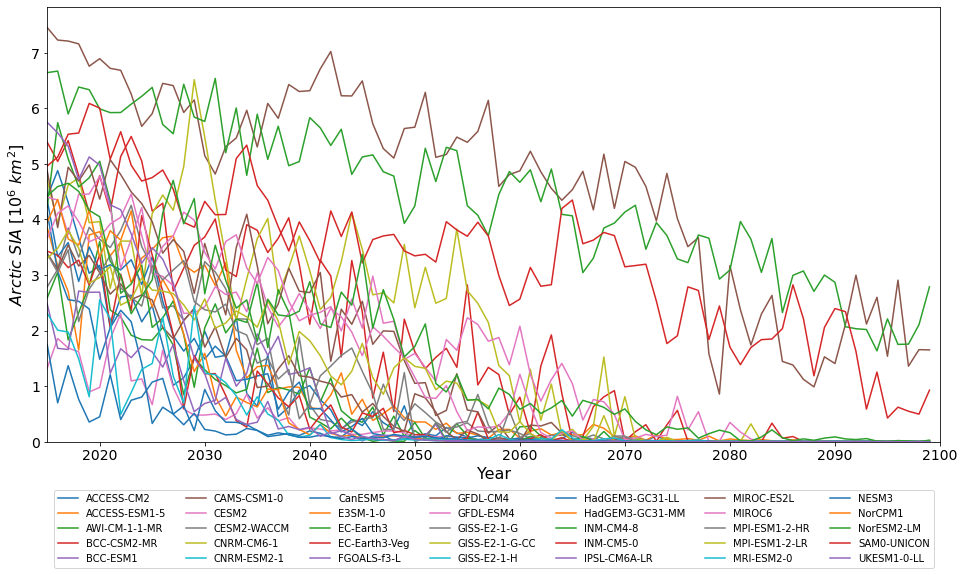

In [47]:
fig = plt.figure(figsize=[16,8])

for model in list(CMIP6_09_SSP585.keys()): #loop through all the models (xarray variables)
    CMIP6_09_SSP585[model].plot(label=model)

#now add extra things to the figure to make it easier to read
plt.legend(bbox_to_anchor=(0.5, -0.29), loc='lower center', borderaxespad=0., ncol=7)
plt.xlim(2015,2100)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.ylim(bottom=0)
plt.ylabel(r'$Arctic \ SIA \ [10^6 \ km^2]$', fontsize=16);
plt.yticks(fontsize=14);

## Now let's get all of the CMIP6 data into a single variable for easier manipulation with `xarray`
**These next 2 cells just convert the text files into a single** `xarray dataarray` **for ease of manipulation**

In [48]:
def txt_to_dataarray(file_name):
    '''
    This function loads CMIP6 text files into memory and converts them into xarray dataarrays
    
    Parameters
    ----------
    file_name : string,
        The file name of the text file, e.g. SIA_CMIP6_historical_March.txt
    
    Returns
    ----------
        xarray dataarray of the text file
    '''
    
    data = pd.read_csv(data_path+'SIA_CMIP6/'+file_name)
    data = xr.Dataset(data)
    data['dim_0'] = data['Year']
    data = data.drop('Year').rename({'dim_0':'Year'})
    
    return(data)

In [57]:
#concatenate the historical and SSP data into a single variable
SSP126_03 = xr.concat((txt_to_dataarray('SIA_CMIP6_historical_March.txt'),     txt_to_dataarray('SIA_CMIP6_ssp126_March.txt')), dim='Year')
SSP126_09 = xr.concat((txt_to_dataarray('SIA_CMIP6_historical_September.txt'), txt_to_dataarray('SIA_CMIP6_ssp126_September.txt')), dim='Year')
SSP245_03 = xr.concat((txt_to_dataarray('SIA_CMIP6_historical_March.txt'),     txt_to_dataarray('SIA_CMIP6_ssp245_March.txt')), dim='Year')
SSP245_09 = xr.concat((txt_to_dataarray('SIA_CMIP6_historical_September.txt'), txt_to_dataarray('SIA_CMIP6_ssp245_September.txt')), dim='Year')
SSP585_03 = xr.concat((txt_to_dataarray('SIA_CMIP6_historical_March.txt'),     txt_to_dataarray('SIA_CMIP6_ssp585_March.txt')), dim='Year')
SSP585_09 = xr.concat((txt_to_dataarray('SIA_CMIP6_historical_September.txt'), txt_to_dataarray('SIA_CMIP6_ssp585_September.txt')), dim='Year')

#convert all the months and SSPs into a single dataset
SIA_CMIP6 = xr.concat((xr.concat((SSP126_03, SSP126_09), dim='month'), xr.concat((SSP245_03, SSP245_09), dim='month'), xr.concat((SSP585_03, SSP585_09), dim='month')), dim='SSP')

In [50]:
SIA_CMIP6 #look at the dataset we've made

In [58]:
#label the SSP and month coordinates correctly, and provide attributes for the dataset
SIA_CMIP6['SSP'] = ['126', '245', '585']
SIA_CMIP6['month'] = [3,9]

SIA_CMIP6.attrs = {'Description' : 'Arctic sea ice area (SIA) for the large ensemble models: CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1. During the historical and RCP8.5 periods 1850-2100, or all available years.',
                   'Units'       : 'million square km',
                   'Timestamp'   : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                   'Data source' : 'CLIVAR Large Ensemble Archive, doi:10.1038/s41558-020-0731-2',
                   'Analysis'    : 'https://github.com/chrisrwp/ATOC_4500/Intro_Timeseries_Histogram.ipynb'}

In [60]:
SIA_CMIP6 #take a look at the new dataset before saving it

In [120]:
SIA_CMIP6.to_netcdf(data_path+'CMIP6_SIA.nc') #save the file as a NetCDF, now you can just open the data in xarray with 1 line

## Plot historical and SSP585

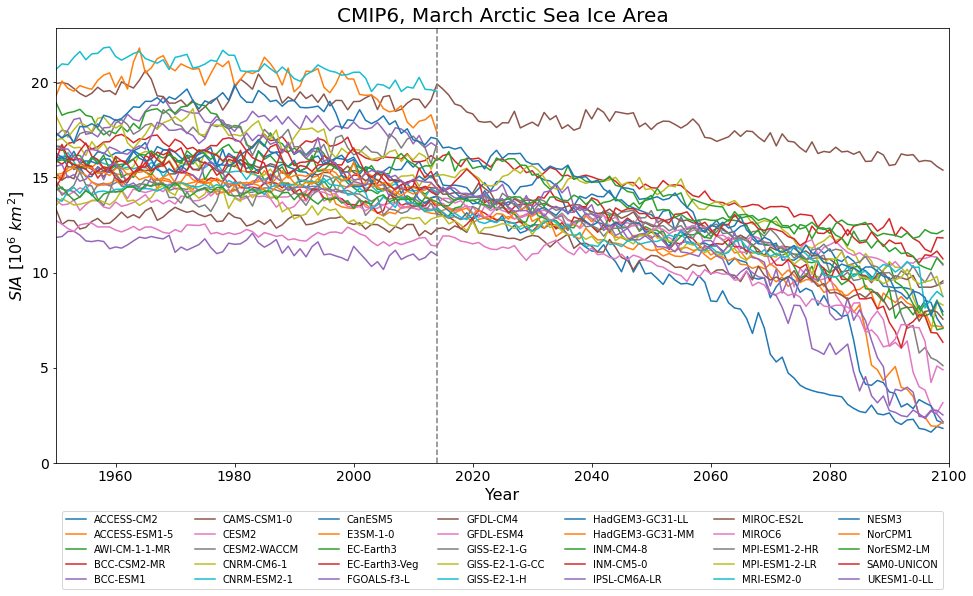

In [61]:
month_ = 3

fig = plt.figure(figsize=[16,8])

for model in list(SIA_CMIP6.keys()): #loop through all the models (xarray variables)
    SIA_CMIP6[model].sel(SSP='585').sel(month=month_).plot(label=model)

plt.axvline(2014, linestyle='--', color='0.5') #plot 2014, the last year of historical simulations
    
plt.legend(bbox_to_anchor=(0.5, -0.29), loc='lower center', borderaxespad=0., ncol=7)
plt.xlim(1950,2100)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.ylim(bottom=0)
plt.ylabel(r'$SIA \ [10^6 \ km^2]$', fontsize=16);
plt.yticks(fontsize=14)
plt.title('CMIP6, '+month_names[month_-1]+' Arctic Sea Ice Area', fontsize=20); #the title should change with the month_ you select

## Plot the multimodel means for the different SSPs

In [62]:
all_models = SIA_CMIP6.to_array(dim='model') #make all of the variables (models) a dimension with coordaintes rather than data variables
#this allows us to compute statistics on the models such as the mean or standard deviation.

In [64]:
all_models #print out the dataset

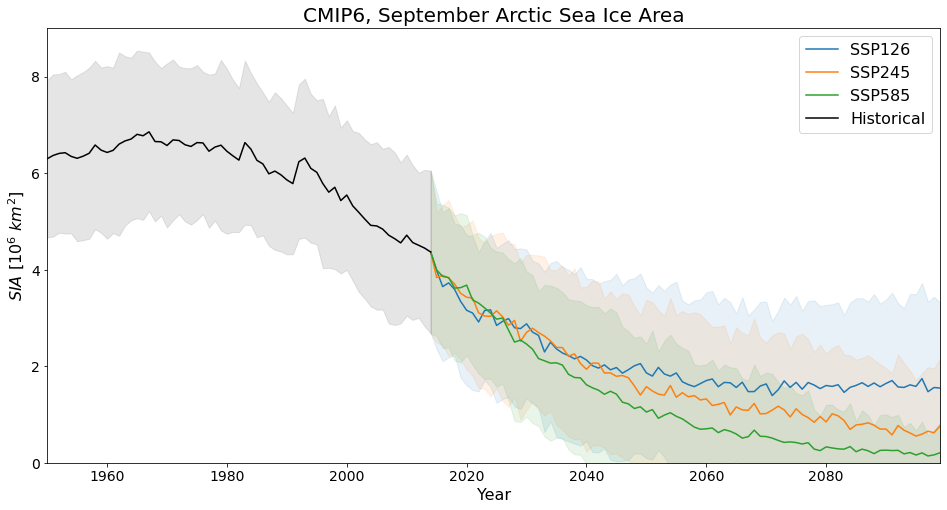

In [71]:
ssp_colors = ['tab:blue', 'tab:orange', 'tab:green']
month_ = 9 #try changing the month to 3 - note how the title also changes

fig = plt.figure(figsize=[16,8])

for ssp_i, ssp in enumerate(all_models['SSP'].values):
    SSP_data = all_models.sel(month=month_).sel(SSP=ssp).sel(Year=slice('2014','2100'))
    
    #plot the multi model mean and standard deviation
    SSP_data.mean('model').plot(label='SSP'+ssp, color=ssp_colors[ssp_i])
    
    plt.fill_between(SSP_data['Year'].values, SSP_data.mean('model') - SSP_data.std('model'), 
                     SSP_data.mean('model') + SSP_data.std('model'), color=ssp_colors[ssp_i], alpha=0.1)

#plot the historical data (1950-2015) in black
hist_data = all_models.sel(month=month_).sel(SSP=ssp).sel(Year=slice('1950','2014'))
plt.plot(hist_data['Year'].values, hist_data.mean('model'), color='k', label='Historical')
plt.fill_between(hist_data['Year'].values, hist_data.mean('model') - hist_data.std('model'), 
                     hist_data.mean('model') + hist_data.std('model'), color='0.5', alpha=0.2)

plt.legend(fontsize=16)
plt.xlim(1950,2099)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.ylim(bottom=0)
plt.ylabel(r'$SIA \ [10^6 \ km^2]$', fontsize=16);
plt.yticks(fontsize=14)
plt.title('CMIP6, '+month_names[month_-1]+' Arctic Sea Ice Area', fontsize=20);